In [38]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score

import re

np.random.seed(23)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Nick\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [39]:
tw_df = pd.read_csv('./data/training.1600000.processed.noemoticon.csv', header=None, encoding='latin').drop(columns=[1, 2, 3, 4])
tw_df.columns = ['sentiment', 'text']

tw_df.head()

,sentiment,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


C:\Users\Nick\miniconda3\envs\stats304\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


,sentiment
count,1.600000e+06
mean,2.000000e+00
std,2.000001e+00
min,0.000000e+00
25%,0.000000e+00
50%,2.000000e+00
75%,4.000000e+00
max,4.000000e+00


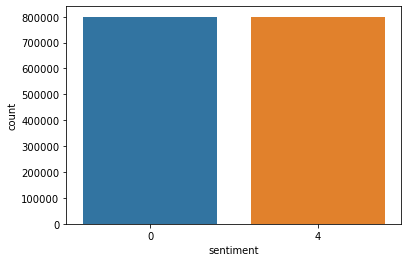

In [40]:
sns.countplot(tw_df['sentiment'])
tw_df.describe()

C:\Users\Nick\miniconda3\envs\stats304\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='sentiment', ylabel='count'>

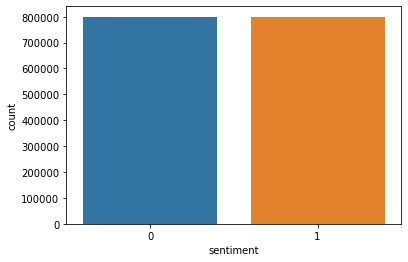

In [41]:
# standarize to 0-1
tw_df['sentiment'] = tw_df['sentiment'].apply(lambda val: 0 if val < 1 else 1)
sns.countplot(tw_df['sentiment'])


In [42]:
stop_words = stopwords.words('english')
stemmer = SnowballStemmer('english')

text_cleaning_re = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

def process_tweet(tweet):
    tweet = re.sub(text_cleaning_re, ' ', str(tweet).lower()).strip()
    tokens = []
    for token in tweet.split():
        if token not in stop_words:
            tokens.append(stemmer.stem(token))
    return ' '.join(tokens)

tw_df['text'] = tw_df['text'].apply(process_tweet)

In [43]:
train_df, test_df = train_test_split(tw_df, test_size=0.2, random_state=23)

In [44]:
vocab_size = 15000

emb_size = 100 # glove vectors are 100 dim

tweet_len = round(tw_df['text'].apply(len).mean())
tweet_len

39

In [46]:
tokenizer = Tokenizer(num_words=vocab_size, lower=True, oov_token='?')
tokenizer.fit_on_texts(train_df['text'])

word_index = tokenizer.word_index

X_train = pad_sequences(tokenizer.texts_to_sequences(train_df.text), maxlen=tweet_len)
X_test = pad_sequences(tokenizer.texts_to_sequences(test_df.text), maxlen=tweet_len)

X_train.shape, X_test.shape, len(word_index)

((1280000, 39), (320000, 39), 249042)

In [47]:
y_train = train_df['sentiment']
y_test = test_df['sentiment']

y_train.shape, y_test.shape

((1280000,), (320000,))

In [48]:
# https://nlp.stanford.edu/projects/glove/
# a function to load vector model as dictionary
def load_glove_model(File):
    glove_model = {}
    with open(File,'r',encoding='utf-8') as f:
        for line in f:
            split_line = line.split()
            word = split_line[0]
            embedding = np.array(split_line[1:], dtype=np.float64)
            glove_model[word] = embedding
    print(f"{len(glove_model)} words loaded")
    return glove_model

glove = load_glove_model('./data/glove.twitter.27B.100d.txt')


1193514 words loaded


In [49]:
len(word_index)

249042

In [50]:
embedding_matrix = np.zeros((vocab_size, emb_size))
for word, i in word_index.items():
  if i >= vocab_size:
    break
  embedding_vector = glove.get(word)
  if embedding_vector is not None:
    embedding_matrix[i] = embedding_vector

In [51]:
input = keras.layers.Input(shape=(tweet_len,), dtype='int32')
embed_layer = keras.layers.Embedding(vocab_size, emb_size, weights=[embedding_matrix], input_length=tweet_len, trainable=False)(input)
x = keras.layers.SpatialDropout1D(0.1)(embed_layer)
x = keras.layers.Conv1D(64, 5, activation='relu')(x)
x = keras.layers.Bidirectional(keras.layers.LSTM(64, dropout=0.2, recurrent_dropout=0.2))(x)
x = keras.layers.Dense(512, activation='relu')(x)
x = keras.layers.Dropout(0.2)(x)
output = keras.layers.Dense(1, activation='sigmoid')(x)

lstm_model = keras.Model(input, output)
lstm_model.summary()

lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

callbacks = [keras.callbacks.ModelCheckpoint('./models/', save_best_only=True),
             keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
             keras.callbacks.EarlyStopping(monitor='val_acc', min_delta=1e-4, patience=5)]

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 39)                0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 39, 100)           1500000   
_________________________________________________________________
spatial_dropout1d_2 (Spatial (None, 39, 100)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 35, 64)            32064     
_________________________________________________________________
bidirectional_2 (Bidirection (None, 128)               66048     
_________________________________________________________________
dense_3 (Dense)              (None, 512)               66048     
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0   

In [52]:
history = lstm_model.fit(X_train, y_train, batch_size=512, epochs=1, validation_data=(X_test, y_test), callbacks=callbacks)

Train on 1280000 samples, validate on 320000 samples
Epoch 1/1
 113664/1280000 [=>............................] - ETA: 21:02 - loss: 0.5795 - accuracy: 0.6905

KeyboardInterrupt: 

In [ ]:
# show the learning process
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epoch_range = range(len(accuracy))

plt.figure(figsize=(10, 6))
plt.plot(epoch_range, accuracy, 'bo', label='Training')
plt.plot(epoch_range, val_accuracy, 'r', label='Test')
plt.xlabel('Epoch', size=18)
plt.ylabel('Accuracy', size=18)
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(epoch_range, loss, 'bo', label='Training')
plt.plot(epoch_range, val_loss, 'r', label='Test')
plt.xlabel('Epoch', size=18)
plt.ylabel('Loss', size=18)
plt.legend()
plt.show()

In [ ]:
y_pred = lstm_model.predict(X_train)

y_train_ = np.argmax(y_train, axis = 1)
y_pred_ = np.argmax(y_pred, axis = 1)

cm1 = confusion_matrix(y_train_, y_pred_)

plt.figure(figsize=(9,9))
sns.heatmap(cm1, annot=True, fmt=".0f", linewidths=.5, square=True, cmap='Blues_r')
plt.ylabel('true number', size=17)
plt.xlabel('predicted number', size=17)
plt.show()

accuracy_score(y_train_, y_pred_)